In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import get_data
np.random.seed(2024)
# train, test = get_data(filepath="processed_data/full_data_secs.csv", size_train=1000, size_test=600)
# train["propleft"] = 1 - train["prop"]
# test["propleft"] = 1 - test["prop"]
# train["propxcurr"] = train["prop"] * train["curr_pace"]
# test["propxcurr"] = test["prop"] * test["curr_pace"]

# train['male'] = train['gender'].apply(lambda x: 1 if x == 'M' else 0)
# test['male'] = test['gender'].apply(lambda x: 1 if x == 'M' else 0)
# train.to_csv("train.csv")
test = pd.read_csv("test.csv")

In [2]:
model_info = {
    # "rstan1a" : ("stan_results/rs_result1a.csv", ["total_pace"], ["beta[1]"], False),
    # "rstan1b" : ("stan_results/rs_result1b.csv", ["total_pace", "curr_pace"], ["beta[1]", "beta[2]"], False),
    # "rstan1c" : ("stan_results/rs_result1c.csv", ["total_pace", "prop"],  ["beta[1]", "beta[2]"], False),
    # "rstan1d" : ("stan_results/rs_result1d.csv", ["total_pace", "curr_pace", "prop"], ["beta[1]", "beta[2]", "beta[3]"], False),

    "rstan2a" : ("stan_results/rs_result2a.csv", ["total_pace"], ["beta[1]"], True),
    "rstan2b" : ("stan_results/rs_result2b.csv", ["total_pace", "curr_pace"],  ["beta[1]", "beta[2]"], True),
    "rstan2c" : ("stan_results/rs_result2c.csv", ["total_pace", "prop"], ["beta[1]", "beta[2]"], True),
    "rstan2d" : ("stan_results/rs_result2d.csv", ["total_pace", "curr_pace", "prop"], ["beta[1]", "beta[2]", "beta[3]"], True),

    "rstan3a" : ("stan_results/rs_result3a.csv", ["total_pace", "curr_pace", "prop", "propxcurr"], ["beta[1]", "beta[2]", "beta[3]", "beta[4]"], True),
    "rstan3b" : ("stan_results/rs_result3b.csv", ["total_pace", "curr_pace", "prop", "propxcurr", "male"], ["beta[1]", "beta[2]", "beta[3]", "beta[4]", "beta[5]"], True),
}

models = {k: pd.read_csv(v[0]) for k, v in model_info.items()}

In [ ]:
def get_preds(test_data, stan_data, feats_lis, beta_lis, name="stan_pred", propleft=False, full=False):
    test_new = test_data.copy()
    d1 = test_new[feats_lis]
    d2 = stan_data[beta_lis].T.copy()

    norm_mean = stan_data["alpha"] + d1.dot(d2.values)
    if propleft: 
        norm_std = np.outer(test_new["propleft"], stan_data["sigma"])
    else:
        norm_std = stan_data["sigma"]
    preds = np.random.normal(norm_mean, norm_std)
    
    if full:
        return preds
    else:
        preds = preds.mean(axis=1)
        test_new[name] = preds
        return test_new 
    

def get_table(test_data, old="stan_pred", new="stan"):
    y_true = (42195 / 60) / test_data["finish"]
    preds = (42195 / 60) / test_data[old]
    extrap = (42195 / 60) / test_data["total_pace"]
    test_data[new] = preds - y_true
    test_data["extrap"] = extrap - y_true
    return test_data

In [4]:
model_preds = {}

for k, v in model_info.items():
    print(k, v)
    preds = get_preds(test, pd.read_csv(v[0]), feats_lis=v[1], beta_lis=v[2], propleft=v[3])
    model_preds[k] = preds

rstan2a ('stan_results/rs_result2a.csv', ['total_pace'], ['beta[1]'], True)
rstan2b ('stan_results/rs_result2b.csv', ['total_pace', 'curr_pace'], ['beta[1]', 'beta[2]'], True)
rstan2c ('stan_results/rs_result2c.csv', ['total_pace', 'prop'], ['beta[1]', 'beta[2]'], True)
rstan2d ('stan_results/rs_result2d.csv', ['total_pace', 'curr_pace', 'prop'], ['beta[1]', 'beta[2]', 'beta[3]'], True)
rstan3a ('stan_results/rs_result3a.csv', ['total_pace', 'curr_pace', 'prop', 'propxcurr'], ['beta[1]', 'beta[2]', 'beta[3]', 'beta[4]'], True)
rstan3b ('stan_results/rs_result3b.csv', ['total_pace', 'curr_pace', 'prop', 'propxcurr', 'male'], ['beta[1]', 'beta[2]', 'beta[3]', 'beta[4]', 'beta[5]'], True)


In [5]:
s_data =pd.DataFrame([[4, 0.2, .5], [3, 0.5, .5]], columns=["total_pace", "prop", "propleft"])
get_preds(s_data, models['rstan2c'], feats_lis = ["total_pace", "prop"], beta_lis = ["beta[1]", "beta[2]"], full=True)

array([[3.51151494, 3.82453593, 3.08483392, ..., 3.7847537 , 3.85104478,
        3.52754848],
       [3.27205203, 3.03340331, 2.98251105, ..., 2.82699627, 2.88986185,
        2.53385792]])

In [7]:
test2 = test.copy()
for k, v in model_preds.items():
    test2[k] = get_table(v)["stan"]
test2["extrap"] = get_table(model_preds["rstan2a"])["extrap"]
test2

,Unnamed: 0,id,dist,curr_pace,total_pace,finish,age,gender,year,prop,propleft,propxcurr,male,rstan2a,rstan2b,rstan2c,rstan2d,rstan3a,rstan3b,extrap
0,28,286805,5K,5.154639,5.154639,5.018435,31,M,2023,0.118497,0.881503,0.610812,1,-2.989805,-2.960136,3.283814,3.318430,0.421210,0.307173,-3.702833
1,71,286848,5K,4.677268,4.677268,4.851115,29,F,2023,0.118497,0.881503,0.554244,0,6.090902,5.763615,13.859772,13.998532,11.428430,10.875908,5.388183
2,85,286862,5K,4.897160,4.897160,4.806904,30,M,2023,0.118497,0.881503,0.580301,1,-1.583082,-1.894667,4.981693,5.096609,2.471550,1.932894,-2.696350
3,120,286897,5K,5.117707,5.117707,4.720855,41,M,2023,0.118497,0.881503,0.606435,1,-10.925150,-11.027639,-4.510068,-4.548798,-7.088955,-7.491100,-11.551617
4,125,286902,5K,4.616805,4.616805,4.707687,23,M,2023,0.118497,0.881503,0.547080,1,3.871981,3.683767,11.645335,11.688807,8.881236,9.206934,2.940617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,208044,312625,40K,2.000000,1.992429,1.986675,56,F,2023,0.947980,0.052020,1.895959,0,1.398427,-1.616995,0.268233,-3.335565,-3.775467,-4.468464,-1.022158
4796,208069,312650,40K,1.803101,1.981768,1.978014,52,M,2023,0.947980,0.052020,1.709303,1,1.821251,1.080931,0.714551,-0.235806,-0.766418,-0.907420,-0.673383
4797,208126,312707,40K,1.631321,1.960977,1.956008,27,F,2023,0.947980,0.052020,1.546459,0,1.594931,2.779815,0.505699,1.914125,1.305604,0.482186,-0.910996
4798,208138,312719,40K,1.728310,1.967439,1.951665,56,F,2023,0.947980,0.052020,1.638402,0,-0.497501,-0.424239,-1.506136,-1.470857,-2.096257,-2.864161,-2.888940


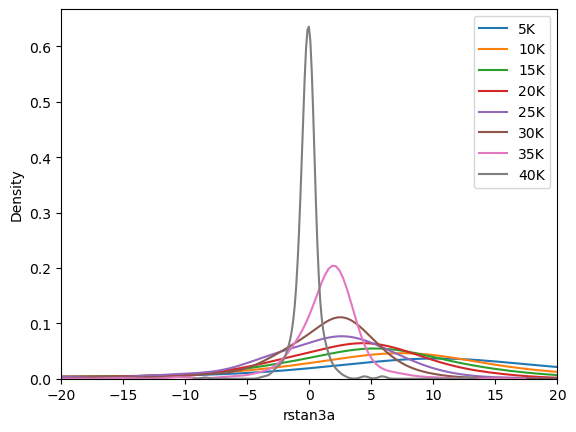

In [8]:
import seaborn as sns
marks = ["5K", "10K", "15K", "20K", "25K", "30K", "35K", "40K"]
for mark in marks:
    sns.kdeplot(test2[test2["dist"] == mark]["rstan3a"], label=mark)
plt.xlim(-20, 20)
plt.legend()

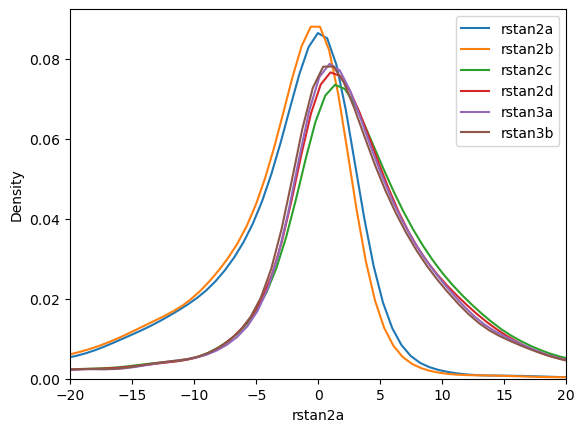

In [9]:
for m in model_info.keys():
    sns.kdeplot(test2[m], label=m)

plt.xlim(-20, 20)
plt.legend()

         extrap    rstan3a    rstan3b    rstan3a    rstan2d
dist                                                       
5K    17.606298  18.411011  18.241450  18.411011  17.623278
10K   16.679752  13.794407  13.698579  13.794407  13.560289
15K   15.372401  11.207767  11.128794  11.207767  11.216596
20K   12.992163   8.974930   8.907476   8.974930   9.004634
25K   10.865553   7.089000   7.058254   7.089000   7.164997
30K    7.749922   5.333133   5.272371   5.333133   5.293107
35K    4.362576   3.475294   3.366362   3.475294   3.367474
40K    1.197432   1.099327   1.161185   1.099327   1.111535


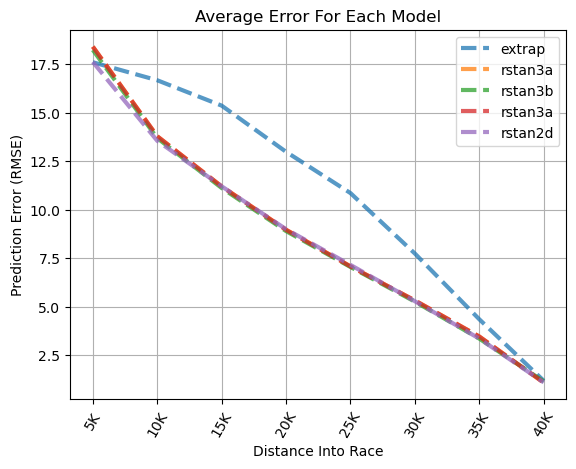

In [10]:

labels = ["extrap", "rstan3a", "rstan3b", "rstan3a", "rstan2d"]
colors = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8"]
colors = ["C0", "C1", "C2", "C3", "C4"]
styles = '--'
mks = ["5K", "10K", "15K", "20K", "25K", "30K", "35K", "40K"]
table_group = test2.groupby(["dist"])[labels].apply(lambda x: (x ** 2).mean() ** 0.5).loc[mks]
print(table_group)
table_group.plot(label=table_group.columns,  style=styles, linewidth=3, grid=True, alpha=0.75, color=colors)

plt.xlabel("Distance Into Race")
plt.ylabel("Prediction Error (RMSE)")
plt.xticks(rotation=60)
plt.title("Average Error For Each Model")
plt.grid(True)
plt.legend()
# plt.savefig("analysis/all_errors3.png", bbox_inches="tight")

In [11]:
model_preds2 = {}

for k, v in model_info.items():
    print(k, v)
    preds = (42195 / 60) / get_preds(test, pd.read_csv(v[0]), feats_lis=v[1], beta_lis=v[2], propleft=v[3], full=True)
    model_preds2[k] = preds

rstan2a ('stan_results/rs_result2a.csv', ['total_pace'], ['beta[1]'], True)
rstan2b ('stan_results/rs_result2b.csv', ['total_pace', 'curr_pace'], ['beta[1]', 'beta[2]'], True)
rstan2c ('stan_results/rs_result2c.csv', ['total_pace', 'prop'], ['beta[1]', 'beta[2]'], True)
rstan2d ('stan_results/rs_result2d.csv', ['total_pace', 'curr_pace', 'prop'], ['beta[1]', 'beta[2]', 'beta[3]'], True)
rstan3a ('stan_results/rs_result3a.csv', ['total_pace', 'curr_pace', 'prop', 'propxcurr'], ['beta[1]', 'beta[2]', 'beta[3]', 'beta[4]'], True)
rstan3b ('stan_results/rs_result3b.csv', ['total_pace', 'curr_pace', 'prop', 'propxcurr', 'male'], ['beta[1]', 'beta[2]', 'beta[3]', 'beta[4]', 'beta[5]'], True)


In [13]:
model_preds2['rstan2a']

array([[128.57314027, 154.75644703, 135.64931783, ..., 137.02276307,
        129.74175131, 146.68674244],
       [171.19229651, 165.35058251, 160.08023711, ..., 163.44536455,
        140.79495253, 153.27772954],
       [173.60509398, 161.73072931, 133.87891785, ..., 139.48418574,
        131.68325042, 143.69281221],
       ...,
       [364.65145367, 362.85596214, 365.2489648 , ..., 356.38925172,
        360.74307519, 367.31539134],
       [356.52045951, 359.98146176, 363.10362495, ..., 360.59019374,
        359.02464995, 360.66626838],
       [376.12113305, 379.59655484, 382.02514015, ..., 382.6749491 ,
        380.88349837, 379.94891907]])

In [14]:
def add_intervals_to_test(data_tbl, preds1, preds2, preds3, preds4):#, q1, q2):
    data = data_tbl.copy()
    for conf, lower, upper in [(50, 25, 75), (80, 10, 90), (95, 2.5, 97.5)]:
        test_true = (42195 / 60) / data["finish"]
        b11, b12 = np.percentile(preds1, [lower, upper], axis=1)
        data[f"stan1-lower{conf}"] = b11
        data[f"stan1-upper{conf}"] = b12
        data[f"stan1-size{conf}"] = b12 - b11
        data[f"stan1-in{conf}"] = (test_true < b12) & (test_true > b11)

        b21, b22 = np.percentile(preds2, [lower, upper], axis=1)
        data[f"stan2-lower{conf}"] = b21
        data[f"stan2-upper{conf}"] = b22
        data[f"stan2-size{conf}"] = b22 - b21
        data[f"stan2-in{conf}"] = (test_true < b22) & (test_true > b21)

        b31, b32 = np.percentile(preds3, [lower, upper], axis=1)
        data[f"stan3-lower{conf}"] = b31
        data[f"stan3-upper{conf}"] = b32
        data[f"stan3-size{conf}"] = b32 - b31
        data[f"stan3-in{conf}"] = (test_true < b32) & (test_true > b31)

        b41, b42 = np.percentile(preds4, [lower, upper], axis=1)
        data[f"stan4-lower{conf}"] = b41
        data[f"stan4-upper{conf}"] = b42
        data[f"stan4-size{conf}"] = b42 - b41
        data[f"stan4-in{conf}"] = (test_true < b42) & (test_true > b41)

    return data

In [15]:
preds1, preds2, preds3, preds4 = model_preds2["rstan2a"], model_preds2["rstan2b"], model_preds2["rstan2c"], model_preds2["rstan2d"]
# preds1, preds2, preds3, preds4 = model_preds2["rstan1a"], model_preds2["rstan1a"], model_preds2["rstan1a"], model_preds2["rstan1a"]
# preds1, preds2, preds3, preds4 = model_preds2["rstan1a"], model_preds2["rstan1a"], model_preds2["rstan1a"], model_preds2["rstan1a"]
table2 = add_intervals_to_test(test2, preds1, preds2, preds3, preds4)
table2

,Unnamed: 0,id,dist,curr_pace,total_pace,finish,age,gender,year,prop,...,stan2-size95,stan2-in95,stan3-lower95,stan3-upper95,stan3-size95,stan3-in95,stan4-lower95,stan4-upper95,stan4-size95,stan4-in95
0,28,286805,5K,5.154639,5.154639,5.018435,31,M,2023,0.118497,...,33.389010,True,129.533196,159.850317,30.317120,True,131.465008,158.969806,27.504798,True
1,71,286848,5K,4.677268,4.677268,4.851115,29,F,2023,0.118497,...,39.750409,True,142.546312,178.982025,36.435713,True,143.992721,178.021036,34.028315,True
2,85,286862,5K,4.897160,4.897160,4.806904,30,M,2023,0.118497,...,36.594503,True,136.890039,170.183247,33.293208,True,137.464805,168.850339,31.385533,True
3,120,286897,5K,5.117707,5.117707,4.720855,41,M,2023,0.118497,...,34.546840,True,130.942809,162.200043,31.257234,True,131.836627,160.061140,28.224513,True
4,125,286902,5K,4.616805,4.616805,4.707687,23,M,2023,0.118497,...,41.515373,True,144.222654,181.719864,37.497211,True,145.535128,179.888715,34.353587,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,208044,312625,40K,2.000000,1.992429,1.986675,56,F,2023,0.947980,...,12.970470,True,349.054264,359.687325,10.633061,True,345.903544,355.575296,9.671751,True
4796,208069,312650,40K,1.803101,1.981768,1.978014,52,M,2023,0.947980,...,13.113505,True,350.844758,361.803978,10.959220,True,350.504381,360.472072,9.967690,True
4797,208126,312707,40K,1.631321,1.960977,1.956008,27,F,2023,0.947980,...,13.647174,True,354.356668,365.970986,11.614318,True,356.241473,366.691821,10.450348,True
4798,208138,312719,40K,1.728310,1.967439,1.951665,56,F,2023,0.947980,...,13.445392,True,353.357576,364.644015,11.286439,True,354.006793,364.085994,10.079201,True


/opt/anaconda3/envs/pyenv10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/opt/anaconda3/envs/pyenv10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/opt/anaconda3/envs/pyenv10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  r

,stan1-in50,stan2-in50,stan3-in50,stan4-in50,stan1-in80,stan2-in80,stan3-in80,stan4-in80,stan1-in95,stan2-in95,stan3-in95,stan4-in95
dist,,,,,,,,,,,,
5K,0.808333,0.775000,0.450000,0.405000,0.951667,0.941667,0.898333,0.845000,0.990000,0.980000,0.990000,0.971667
10K,0.781667,0.743333,0.540000,0.501667,0.936667,0.923333,0.933333,0.913333,0.986667,0.980000,0.991667,0.985000
15K,0.743333,0.693333,0.580000,0.543333,0.916667,0.911667,0.943333,0.923333,0.978333,0.975000,0.985000,0.980000
20K,0.711667,0.678333,0.600000,0.570000,0.915000,0.905000,0.930000,0.918333,0.975000,0.973333,0.985000,0.976667
25K,0.675000,0.630000,0.635000,0.618333,0.906667,0.896667,0.920000,0.905000,0.970000,0.961667,0.976667,0.973333
30K,0.703333,0.695000,0.578333,0.566667,0.911667,0.916667,0.896667,0.905000,0.971667,0.970000,0.971667,0.968333
35K,0.743333,0.820000,0.483333,0.498333,0.940000,0.958333,0.860000,0.905000,0.978333,0.983333,0.971667,0.981667
40K,0.355000,0.616667,0.483333,0.713333,0.740000,0.940000,0.838333,0.915000,0.968333,0.983333,0.966667,0.976667


<Figure size 4000x4000 with 0 Axes>

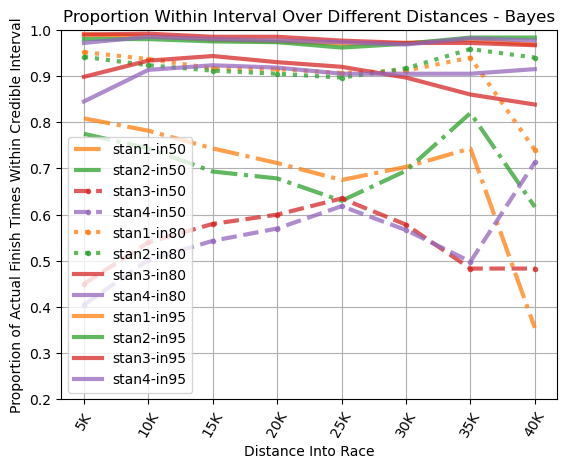

In [16]:
colors = ['C1', 'C2', 'C3', 'C4'] * 3
tables = []
for conf, style in [(50, "-."), (80, "--."), (95, ":.")]:
    sublabels = [f"stan1-in{conf}", f"stan2-in{conf}", f"stan3-in{conf}", f"stan4-in{conf}"]
    table3 = table2.groupby(["dist"])[sublabels].apply(lambda x: np.sum(x) / len(x)).loc[mks]
    tables.append(table3)

plt.figure(figsize=(40, 40))
big_table = pd.concat(tables, axis=1)
big_table.plot(label=big_table.columns,  style=["-."] * 2 + ["--."] * 2 + [":."] * 2 , linewidth=3, grid=True, alpha=0.75, color=colors)
# plt.ylim(0.2, 1) 
plt.legend(loc="lower center")

plt.xlabel("Distance Into Race")
plt.ylabel("Proportion of Actual Finish Times Within Credible Interval")
plt.xticks(rotation=60)
plt.ylim(0.2, 1)
plt.title("Proportion Within Interval Over Different Distances - Bayes")
plt.grid(True)
plt.legend()
# plt.savefig("analysis/interval_check_bayes.png", bbox_inches="tight")
big_table

<Figure size 3000x2000 with 0 Axes>

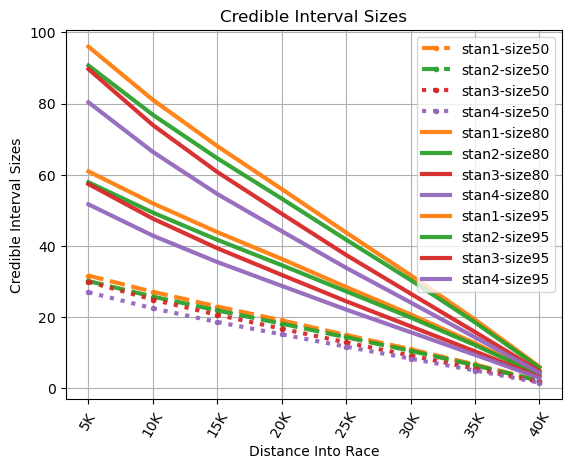

In [17]:
colors = ['C1', 'C2', 'C3', 'C4'] * 3
tables = []
for conf, style in [(50, "-."), (80, "--."), (95, ":.")]:
    sublabels = [f"stan1-size{conf}", f"stan2-size{conf}", f"stan3-size{conf}", f"stan4-size{conf}"]
    table3 = table2.groupby(["dist"])[sublabels].apply(lambda x: (x ** 2).mean() ** 0.5).loc[mks]
    tables.append(table3)

plt.figure(figsize=(30, 20))
big_table = pd.concat(tables, axis=1)
big_table.plot(label=big_table.columns,  style= ["--."] * 2 + [":."] * 2 , linewidth=3, grid=True, alpha=0.95, color=colors)

plt.xlabel("Distance Into Race")
plt.ylabel("Credible Interval Sizes")
plt.xticks(rotation=60)
plt.title("Credible Interval Sizes")
plt.grid(True)
plt.savefig("analysis/interval_sizes_bayes2.png", bbox_inches="tight")
